**You may need to install [OpenCV](https://pypi.python.org/pypi/opencv-python) and [scikit-video](http://www.scikit-video.org/stable/).**

In [1]:
## install dependencies for google colab
!pip install scikit-video
!pip install opencv-python

## check that GPU is enabled for keras
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
from keras import backend as K
K.tensorflow_backend._get_available_gpus()


     |████████████████████████████████| 2.3MB 3.5MB/s 


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0





Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [0]:
import keras
import numpy as np
import io
import base64
from IPython.display import HTML
import skvideo.io
import cv2
import json
import random
import tqdm


from keras.models import Sequential,model_from_json
from keras.layers.core import Dense,Flatten
from keras.optimizers import sgd
from keras.layers import Conv2D, MaxPooling2D, Activation, AveragePooling2D,Reshape,BatchNormalization

# MiniProject on Deep Reinforcement Learning

__Notations__: $E_p$ is the expectation under probability $p$. Please justify each of your answer and widely comment your code.

# Context

In a reinforcement learning algorithm, we modelize each step $t$ as an action $a_t$ obtained from a state $s_t$, i.e. $\{(a_{t},s_{t})_{t\leq T}\}$ having the Markov property. We consider a discount factor $\gamma \in [0,1]$ that ensures convergence. The goal is to find among all the policies $\pi$, one that maximizes the expected reward:

\begin{equation*}
R(\pi)=\sum_{t\leq T}E_{p^{\pi}}[\gamma^t r(s_{t},a_{t})] \> ,
\end{equation*}

where: 
\begin{equation*}p^{\pi}(a_{0},a_{1},s_{1},...,a_{T},s_{T})=p(a_{0})\prod_{t=1}^{T}\pi(a_{t}|s_{t})p(s_{t+1}|s_{t},a_{t}) \> .
\end{equation*}

We note the $Q$-function:

\begin{equation*}Q^\pi(s,a)=E_{p^{\pi}}[\sum_{t\leq T}\gamma^{t}r(s_{t},a_{t})|s_{0}=s,a_{0}=a] \> .
\end{equation*}

Thus, the optimal Q function is:
\begin{equation*}
Q^*(s,a)=\max_{\pi}Q^\pi(s,a) \> .
\end{equation*}

In this project, we will apply the deep reinforcement learning techniques to a simple game: an agent will have to learn from scratch a policy that will permit it maximizing a reward.

## The environment, the agent and the game

### The environment

```Environment``` is an abstract class that represents the states, rewards, and actions to obtain the new state.

In [0]:
class Environment(object):
    def __init__(self):
        pass

    def act(self, act):
        """
        One can act on the environment and obtain its reaction:
        - the new state
        - the reward of the new state
        - should we continue the game?

        :return: state, reward, game_over
        """
        pass


    def reset(self):
        """
        Reinitialize the environment to a random state and returns
        the original state

        :return: state
        """
        pass
    
    def draw(self):
        """
        Visualize in the console or graphically the current state
        """
        pass

The method ```act``` allows to act on the environment at a given state $s_t$ (stored internally), via action $a_t$. The method will return the new state $s_{t+1}$, the reward $r(s_{t},a_{t})$ and determines if $t\leq T$ (*game_over*).

The method ```reset``` simply reinitializes the environment to a random state $s_0$.

The method ```draw``` displays the current state $s_t$ (this is useful to check the behavior of the Agent).

We modelize $s_t$ as a tensor, while $a_t$ is an integer.

### The Agent

The goal of the ```Agent``` is to interact with the ```Environment``` by proposing actions $a_t$ obtained from a given state $s_t$ to attempt to maximize its __reward__ $r(s_t,a_t)$. We propose the following abstract class:

In [0]:
class Agent(object):
    def __init__(self, epsilon=0.1, n_action=4):
        self.epsilon = epsilon
        self.n_action = n_action
    
    def set_epsilon(self,e):
        return
        
    def act(self,s,train=True):
        """ This function should return the next action to do:
        an integer between 0 and 4 (not included) with a random exploration of epsilon"""
        if train:
            if np.random.rand() <= self.epsilon:
                a = np.random.randint(0, self.n_action, size=1)[0]
            else:
                a = self.learned_act(s)
        else: # in some cases, this can improve the performance.. remove it if poor performances
            a = self.learned_act(s)

        return a

    def learned_act(self,s):
        """ Act via the policy of the agent, from a given state s
        it proposes an action a"""
        pass

    def reinforce(self, s, n_s, a, r, game_over_):
        """ This function is the core of the learning algorithm. 
        It takes as an input the current state s_, the next state n_s_
        the action a_ used to move from s_ to n_s_ and the reward r_.
        
        Its goal is to learn a policy.
        """
        pass

    def save(self):
        """ This function returns basic stats if applicable: the
        loss and/or the model"""
        pass

    def load(self):
        """ This function allows to restore a model"""
        pass

***
__Question 1__:
Explain the function act. Why is ```epsilon``` essential?

# Answer 1

In the function act, we either :
- sample the action $a_t$ under our given policy with probability $1-\epsilon$
- chose a random action $a_t$ with probability $\epsilon$

The goal of this method is to ensure that the Agent will continue to explore the environment through the whole training whatever policy training method we chose. Thus the choice of $\epsilon$ is essential. It will dictate how likely the Agent will follow the training method we implement.

***
### The Game

The ```Agent``` and the ```Environment``` work in an interlaced way as in the following (take some time to understand this code as it is the core of the project)

```python

epoch = 300
env = Environment()
agent = Agent()


# Number of won games
score = 0
loss = 0


for e in range(epoch):
    # At each epoch, we restart to a fresh game and get the initial state
    state = env.reset()
    # This assumes that the games will end
    game_over = False

    win = 0
    lose = 0
    
    while not game_over:
        # The agent performs an action
        action = agent.act(state)

        # Apply an action to the environment, get the next state, the reward
        # and if the games end
        prev_state = state
        state, reward, game_over = env.act(action)

        # Update the counters
        if reward > 0:
            win = win + reward
        if reward < 0:
            lose = lose -reward

        # Apply the reinforcement strategy
        loss = agent.reinforce(prev_state, state,  action, reward, game_over)

    # Save as a mp4
    if e % 10 == 0:
        env.draw(e)

    # Update stats
    score += win-lose

    print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
          .format(e, epoch, loss, win, lose, win-lose))
    agent.save()
```

# The game, *eat cheese*

A rat runs on an island and tries to eat as much as possible. The island is subdivided into $N\times N$ cells, in which there are cheese (+0.5) and poisonous cells (-1). The rat has a visibility of 2 cells (thus it can see $5^2$ cells). The rat is given a time $T$ to accumulate as much food as possible. It can perform 4 actions: going up, down, left, right. 

The goal is to code an agent to solve this task that will learn by trial and error. We propose the following environment:

In [0]:
class Environment(object):
    def __init__(self, grid_size=10, max_time=500, temperature=0.1):
        grid_size = grid_size+4
        self.grid_size = grid_size
        self.max_time = max_time
        self.temperature = temperature

        #board on which one plays
        self.board = np.zeros((grid_size,grid_size))
        self.position = np.zeros((grid_size,grid_size))

        # coordinate of the cat
        self.x = 0
        self.y = 1

        # self time
        self.t = 0

        self.scale=16

        self.to_draw = np.zeros((max_time+2, grid_size*self.scale, grid_size*self.scale, 3))


    def draw(self,e):
        skvideo.io.vwrite(str(e) + '.mp4', self.to_draw)

    def get_frame(self,t):
        # I changed the colors to get green for bonuses and red for maluses
        b = np.zeros((self.grid_size,self.grid_size,3))+128
        b[self.board>0,1] = 256
        b[self.board < 0, 0] = 256
        b[self.x,self.y,:]=256
        b[-2:,:,:]=0
        b[:,-2:,:]=0
        b[:2,:,:]=0
        b[:,:2,:]=0
        
        b =  cv2.resize(b, None, fx=self.scale, fy=self.scale, interpolation=cv2.INTER_NEAREST)

        self.to_draw[t,:,:,:]=b

    #adding a variable train for the following questions
    def act(self, action,training='False'):
        """This function returns the new state, reward and decides if the
        game ends."""

        self.get_frame(int(self.t))

        self.position = np.zeros((self.grid_size, self.grid_size))

        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[-2:, :] = -1

        self.position[self.x, self.y] = 1
        if action == 0:
            if self.x == self.grid_size-3:
                self.x = self.x-1
            else:
                self.x = self.x + 1
        elif action == 1:
            if self.x == 2:
                self.x = self.x+1
            else:
                self.x = self.x-1
        elif action == 2:
            if self.y == self.grid_size - 3:
                self.y = self.y - 1
            else:
                self.y = self.y + 1
        elif action == 3:
            if self.y == 2:
                self.y = self.y + 1
            else:
                self.y = self.y - 1
        else:
            RuntimeError('Error: action not recognized')

        self.t = self.t + 1
        reward = self.board[self.x, self.y]
        self.board[self.x, self.y] = 0
        game_over = self.t > self.max_time
        state = np.concatenate((self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)
        state = state[self.x-2:self.x+3,self.y-2:self.y+3,:]

        return state, reward, game_over

    def reset(self):
        """This function resets the game and returns the initial state"""

        self.x = np.random.randint(3, self.grid_size-3, size=1)[0]
        self.y = np.random.randint(3, self.grid_size-3, size=1)[0]


        bonus = 0.5*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        bonus = bonus.reshape(self.grid_size,self.grid_size)

        malus = -1.0*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        malus = malus.reshape(self.grid_size, self.grid_size)

        self.to_draw = np.zeros((self.max_time+2, self.grid_size*self.scale, self.grid_size*self.scale, 3))


        malus[bonus>0]=0

        self.board = bonus + malus

        self.position = np.zeros((self.grid_size, self.grid_size))
        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[-2:, :] = -1
        self.board[self.x,self.y] = 0
        self.t = 0

        state = np.concatenate((
                               self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)

        state = state[self.x - 2:self.x + 3, self.y - 2:self.y + 3, :]
        return state

The following elements are important because they correspond to the hyper parameters for this project:

In [0]:
# parameters
size = 13
T=200
temperature=0.3
epochs_train=10 # set small when debugging
epochs_test=5 # set small when debugging

# display videos
def display_videos(name):
    video = io.open(name, 'r+b').read()
    encoded = base64.b64encode(video)
    return '''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))

__Question 2__ Explain the use of the arrays ```position``` and ```board```.

# Answer 2
Both are 2 dimensional arrays of size (grid_size+4,grid_size+4). The padding is here to send the visualisation information of 25 cells even if we are near a border. We can always see 2 cases ahead (they might be blank).

- The array board contains informations about the bonus / malus available. It is a two dimensional matrix where board[i,j] indicates the values of the bonus/malus. At building time, the cell has no value. Then a realisation of a bernoulli distribution of parameter *temperature* decides if it will have a malus. Another realisation of the same distribution decides it if will have a bonus (eventually replacing the malus).

- The array position contains our position on the map. It is used to show the 25 cells seeable by the Agent without problem when he is near a border.

## Random Agent

***
__Question 3__ Implement a random Agent (only ```learned_act``` needs to be implemented):

In [0]:
class RandomAgent(Agent):
    def __init__(self):
        super(RandomAgent, self).__init__()
        pass

    def learned_act(self, s):
        return np.random.randint(4)

***
***
__Question 4__ Visualize the game moves. You need to fill in the following function for the evaluation:

In [0]:
def test(agent,env,epochs,prefix=''):
    # Number of won games
    score = 0
        
    for e in range(epochs):
        

        state = env.reset()
        # This assumes that the games will end
        game_over = False

        win = 0
        lose = 0

        while not game_over:
            # The agent performs an action
            action = agent.act(state,train='False')
            
            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            prev_state = state
            state, reward, game_over = env.act(action,training='False')
            # Update the counters
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose -reward

            
        
        
        # Save as a mp4
        env.draw(prefix+str(e))

        # Update stats
        score = score + win-lose

        print("Win/lose count {}/{}. Average score ({})"
              .format(win, lose, score/(1+e)))
    print('Final score: '+str(score/epochs))
    ## adding a return statement to get the final score
    return score/epochs

In [8]:
# Initialize the game
env = Environment(grid_size=size, max_time=T,temperature=temperature)

# Initialize the agent!
agent = RandomAgent()

test(agent,env,epochs_test,prefix='random')
HTML(display_videos('random0.mp4'))

Win/lose count 9.0/17.0. Average score (-8.0)
Win/lose count 11.5/9.0. Average score (-2.75)
Win/lose count 12.5/14.0. Average score (-2.3333333333333335)
Win/lose count 12.5/17.0. Average score (-2.875)
Win/lose count 9.0/11.0. Average score (-2.7)
Final score: -2.7


***
## DQN

Let us assume here that $T=\infty$.

***
__Question 5__ Let $\pi$ be a policy, show that:

\begin{equation*}
Q^{\pi}(s,a)=E_{(s',a')\sim p(.|s,a)}[r(s,a)+\gamma Q^{\pi}(s',a')]
\end{equation*}

Then, show that for the optimal policy $\pi^*$ (we assume its existence), the following holds: 

\begin{equation*}
Q^{*}(s,a)=E_{s'\sim \pi^*(.|s,a)}[r(s,a)+\gamma\max_{a'}Q^{*}(s',a')].
\end{equation*}
Finally, deduce that a plausible objective is:

\begin{equation*}
\mathcal{L}(\theta)=E_{s' \sim \pi^*(.|s,a)}\Vert r+\gamma\max_{a}Q(s',a,\theta)-Q(s,a,\theta)\Vert^{2}.
\end{equation*}




## Answer 5 :
By definition :
$$ Q^\pi(s,a)=E_{p^{\pi}}[\sum_{t=0}\gamma^{t}r(s_{t},a_{t})|s_{0}=s,a_{0}=a] $$

$$ Q^\pi(s,a)=E_{p^{\pi}}[\sum_{t \geq 1}\gamma^{t}r(s_{t},a_{t}) + r(s_0,a_0)|s_{0}=s,a_{0}=a] $$

$$ Q^\pi(s,a)=E_{p^{\pi}}[\gamma\sum_{t \geq 1}\gamma^{t-1}r(s_{t},a_{t}) + r(s_0,a_0)|s_{0}=s,a_{0}=a] $$

$$ Q^\pi(s,a) = r(s,a) + \gamma E_{p^{\pi}}[\sum_{t \geq 0}\gamma^{t}r(s_{t+1},a_{t+1}) |s_{0}=s,a_{0}=a]   $$

with
$$
E_{p^{\pi}}[\sum_{t \geq 0}\gamma^{t}r(s_{t+1},a_{t+1}) |s_{0}=s,a_{0}=a] = \sum_{a',s'} P^{\pi}(s_1 = s',a_1 = a') E_{p^{\pi}}[\sum_{t \geq 0}\gamma^{t}r(s_{t+1},a_{t+1}) |s_{1}=s',a_{1}=a'] =
\sum_{a',s'} P^{\pi}(s_1 = s',a_1 = a')Q^{\pi}(s';a')
$$

So 
$$Q^{\pi}(s,a)=E_{(s',a')\sim p^{\pi}(.|s,a)}[r(s,a)+\gamma Q^{\pi}(s',a')] $$.

For the optimal policy : 
$$Q^{\pi^*}(s,a)= \underset{\pi}{max} \;Q^{\pi}(s,a) = \underset{\pi}{max} \; E_{(s',a')\sim \pi(.|s,a)}[r(s,a)+\gamma Q^{\pi}(s',a')] $$

To maximize with respect to the policy we have to chose the best action :

$$
Q^{\pi^*}(s,a) = \underset{\pi, a' }{max} \; E_{(s')\sim \pi(.|s,a)}[r(s,a)+\gamma Q^{\pi}(s',a')] 
$$
$$
 Q^{\pi^*}(s,a) = \underset{\pi }{max} \; E_{(s')\sim \pi(.|s,a)}[r(s,a)+\gamma \underset{a'}{max} \; Q^{\pi}(s',a')]
$$
$$
 Q^{\pi^*}(s,a) =  E_{(s')\sim \pi^*(.|s,a)}[r(s,a)+\gamma \underset{a'}{max} \; Q^{\pi^*}(s',a')]
$$


We showed that the optimal Q function is the fixed point of the optimal Bellman operator. Thus it is a good choice of loss to reduce the difference between the two terms : $Q^{\pi}(s,a,\theta)$ and $E_{s' \sim \pi^*(.|s,a)} [ r+\gamma\max_{a}Q^{\pi}(s',a,\theta)]$. If we chose the L2 norm we get $$
\mathcal{L}(\theta)=E_{s' \sim \pi^*(.|s,a)}\Vert r+\gamma\max_{a}Q(s',a,\theta)-Q(s,a,\theta)\Vert^{2}. $$

***
The DQN-learning algorithm relies on these derivations to train the parameters $\theta$ of a Deep Neural Network:

1. At the state $s_t$, select the action $a_t$ with best reward using $Q_t$ and store the results;

2. Obtain the new state $s_{t+1}$ from the environment $p$;

3. Store $(s_t,a_t,s_{t+1})$;

4. Obtain $Q_{t+1}$ by minimizing  $\mathcal{L}$ from a recovered batch from the previously stored results.

***
__Question 6__ Implement the class ```Memory``` that stores moves (in a replay buffer) via ```remember``` and provides a ```random_access``` to these. Specify a maximum memory size to avoid side effects. You can for example use a ```list()``` and set by default ```max_memory=100```.

In [0]:
class Memory(object):
    def __init__(self, max_memory=100):
        self.max_memory = max_memory
        self.memory = list()
        self.position = 0

    def remember(self, m):
        #we append the move if the memory is not full
        if len(self.memory) < self.max_memory : 
            self.memory.append(None)
        self.memory[self.position] = m
        self.position = (self.position +1 )% self.max_memory

    def random_access(self):
        if len(self.memory) == 1:
            return self.memory[0]
        else:
            return self.memory[np.random.randint(0,len(self.memory)-1)]
        

***
The pipeline we will use for training is given below:

In [0]:
def train(agent,env,epoch,prefix=''):
    # Number of won games
    score = 0
    loss = 0

    for e in range(epoch):
        # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()
        # This assumes that the games will terminate
        game_over = False

        win = 0
        lose = 0

        while not game_over:
            # The agent performs an action
            action = agent.act(state)

            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            prev_state = state
            state, reward, game_over = env.act(action)

            # Update the counters
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose -reward

            # Apply the reinforcement strategy
            loss = agent.reinforce(prev_state, state,  action, reward, game_over)

        # Save as a mp4
        if e % 10 == 0:
            env.draw(prefix+str(e))

        # Update stats
        score += win-lose

        print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
              .format(e, epoch, loss, win, lose, win-lose))
        agent.save(name_weights=prefix+'model.h5',name_model=prefix+'model.json')

***
__Question 7__ Implement the DQN training algorithm using a cascade of fully connected layers. You can use different learning rate, batch size or memory size parameters. In particular, the loss might oscillate while the player will start to win the games. You have to find a good criterium.

In [0]:
class DQN(Agent):
    def __init__(self, grid_size,  epsilon = 0.1, memory_size=100, batch_size = 16,n_state=2):
        super(DQN, self).__init__(epsilon = epsilon)

        # Discount for Q learning
        self.discount = 0.99
        
        self.grid_size = grid_size
        
        # number of state
        self.n_state = n_state

        # Memory
        self.memory = Memory(memory_size)
        
        # Batch size when learning
        self.batch_size = batch_size

    def learned_act(self, s):
        actions_returns = self.model.predict(np.expand_dims(s,0))
        return np.argmax(actions_returns)

    def reinforce(self, s_, n_s_, a_, r_, game_over_):
        # Two steps: first memorize the states, second learn from the pool

        self.memory.remember([s_, n_s_, a_, r_, game_over_])
        
        input_states = np.zeros((self.batch_size, 5,5,self.n_state))
        target_q = np.zeros((self.batch_size, 4))
        
        for i in range(self.batch_size):
            ## first we get a sample
            s, n_s , a , r , game_over_ = self.memory.random_access()
            input_states[i] = s
            target_q[i] = self.model.predict(np.expand_dims(s,0))
            if game_over_:
                target_q[i][a] = r
            else:
                target_q[i][a] = r + self.discount*np.amax(self.model.predict(np.expand_dims(n_s,0)))
                
        
        
        # HINT: Clip the target to avoid exploiding gradients.. -- clipping is a bit tighter
        target_q = np.clip(target_q, -3, 3)

        l = self.model.train_on_batch(input_states, target_q)


        return l

    def save(self,name_weights='model.h5',name_model='model.json'):
        self.model.save_weights(name_weights, overwrite=True)
        with open(name_model, "w") as outfile:
            json.dump(self.model.to_json(), outfile)
            
    def load(self,name_weights='model.h5',name_model='model.json'):
        with open(name_model, "r") as jfile:
            model = model_from_json(json.load(jfile))
        model.load_weights(name_weights)
        model.compile("sgd", "mse")
        self.model = model

            
class DQN_FC(DQN):
    def __init__(self, *args, lr=0.1,**kwargs):
        super(DQN_FC, self).__init__( *args,**kwargs)
        
        # NN Model
        model = Sequential([
        Flatten(),
        Dense(128, input_shape=(50,)),
        Activation('relu'),
        Dense(256),
        Activation('relu'),
        Dense(4),
        Activation('relu'),
                ])
        

        
        model.compile(sgd(lr=lr, decay=1e-4, momentum=0.0), "mse")
        self.model = model

    #for the last question
    # e is the epoch
    def set_epsilon(self,e):
        self.epsilon = self.epsilon *(e-1) /e

        

In [12]:
env = Environment(grid_size=size, max_time=T, temperature=0.3)
agent = DQN_FC(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32)
train(agent, env, epochs_train, prefix='fc_train')
HTML(display_videos('fc_train0.mp4'))









Epoch 000/010 | Loss 0.0835 | Win/lose count 3.5/4.0 (-0.5)
Epoch 001/010 | Loss 0.0551 | Win/lose count 1.5/2.0 (-0.5)
Epoch 002/010 | Loss 0.0022 | Win/lose count 1.5/4.0 (-2.5)
Epoch 003/010 | Loss 0.1141 | Win/lose count 2.0/7.0 (-5.0)
Epoch 004/010 | Loss 0.0014 | Win/lose count 2.0/4.0 (-2.0)
Epoch 005/010 | Loss 0.0416 | Win/lose count 2.0/3.0 (-1.0)
Epoch 006/010 | Loss 0.0396 | Win/lose count 1.0/1.0 (0.0)
Epoch 007/010 | Loss 0.0554 | Win/lose count 2.5/2.0 (0.5)
Epoch 008/010 | Loss 0.0048 | Win/lose count 4.0/3.0 (1.0)
Epoch 009/010 | Loss 0.0025 | Win/lose count 1.5/1.0 (0.5)


***
***
__Question 8__ Implement the DQN training algorithm using a CNN (for example, 2 convolutional layers and one final fully connected layer).

In [0]:
class DQN_CNN(DQN):
    def __init__(self, *args,lr=0.1,**kwargs):
        super(DQN_CNN, self).__init__(*args,**kwargs)
        
        model = Sequential()
        model.add(Conv2D(8,(2,2)))
        model.add(Activation('relu'))
        model.add(Conv2D(32,(2,2)))
        model.add(Activation('relu'))
        model.add(Flatten())
        model.add(Dense(4))
        
        model.compile(sgd(lr=lr, decay=1e-4, momentum=0.0), "mse")
        self.model = model

In [14]:
env = Environment(grid_size=size, max_time=T, temperature=0.3)
agent = DQN_CNN(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32)
train(agent,env,epochs_train,prefix='cnn_train')
HTML(display_videos('cnn_train0.mp4'))

Epoch 000/010 | Loss 0.0011 | Win/lose count 1.5/1.0 (0.5)
Epoch 001/010 | Loss 0.0137 | Win/lose count 0/7.0 (-7.0)
Epoch 002/010 | Loss 0.0059 | Win/lose count 4.5/5.0 (-0.5)
Epoch 003/010 | Loss 0.0035 | Win/lose count 4.0/3.0 (1.0)
Epoch 004/010 | Loss 0.0140 | Win/lose count 4.5/3.0 (1.5)
Epoch 005/010 | Loss 0.0019 | Win/lose count 8.0/3.0 (5.0)
Epoch 006/010 | Loss 0.0082 | Win/lose count 1.5/2.0 (-0.5)
Epoch 007/010 | Loss 0.0037 | Win/lose count 5.0/4.0 (1.0)
Epoch 008/010 | Loss 0.0147 | Win/lose count 3.5/0 (3.5)
Epoch 009/010 | Loss 0.0453 | Win/lose count 2.0/1.0 (1.0)


***
***
__Question 9__ Test both algorithms and compare their performances. Which issue(s) do you observe? Observe also different behaviors by changing the temperature.

In [15]:
env = Environment(grid_size=size, max_time=T,temperature=0.3)
agent_cnn = DQN_CNN(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32)
agent_cnn.load(name_weights='cnn_trainmodel.h5',name_model='cnn_trainmodel.json')

agent_fc = DQN_FC(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32)
agent_cnn.load(name_weights='fc_trainmodel.h5',name_model='fc_trainmodel.json')
print('Test of the CNN')
test(agent_cnn,env,epochs_test,prefix='cnn_test')
print('Test of the FC')
test(agent_fc,env,epochs_test,prefix='fc_test')

Test of the CNN
Win/lose count 4.0/5.0. Average score (-1.0)
Win/lose count 3.5/4.0. Average score (-0.75)
Win/lose count 1.5/1.0. Average score (-0.3333333333333333)
Win/lose count 5.0/3.0. Average score (0.25)
Win/lose count 2.5/6.0. Average score (-0.5)
Final score: -0.5
Test of the FC
Win/lose count 3.0/2.0. Average score (1.0)
Win/lose count 2.0/2.0. Average score (0.5)
Win/lose count 5.5/2.0. Average score (1.5)
Win/lose count 3.5/6.0. Average score (0.5)
Win/lose count 4.0/2.0. Average score (0.8)
Final score: 0.8


0.8

In [17]:
temp_values = np.linspace(0.2,1,5)
final_scores_FC = []
final_scores_CNN = []
epochs_test = 5
epochs_train = 10
for temp in tqdm.tqdm(temp_values):
    env = Environment(grid_size=size, max_time=T,temperature=temp)
    agent_cnn = DQN_CNN(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32)
    agent_fc = DQN_FC(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32)
    train(agent_cnn,env,epochs_train,prefix='cnn_train_'+str(temp))
    train(agent_fc,env,epochs_train,prefix='fc_train_'+str(temp))
    final_scores_FC.append(test(agent_fc,env,epochs_test,prefix='fc_test_'+str(temp)))
    final_scores_CNN.append(test(agent_cnn,env,epochs_test,prefix='cnn_test_'+str(temp)))
    
    


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 000/010 | Loss 0.0020 | Win/lose count 1.0/1.0 (0.0)
Epoch 001/010 | Loss 0.0003 | Win/lose count 1.5/3.0 (-1.5)
Epoch 002/010 | Loss 0.0006 | Win/lose count 1.5/4.0 (-2.5)
Epoch 003/010 | Loss 0.0103 | Win/lose count 5.5/3.0 (2.5)
Epoch 004/010 | Loss 0.0150 | Win/lose count 0.5/0 (0.5)
Epoch 005/010 | Loss 0.0149 | Win/lose count 1.5/1.0 (0.5)
Epoch 006/010 | Loss 0.0032 | Win/lose count 3.5/2.0 (1.5)
Epoch 007/010 | Loss 0.0094 | Win/lose count 0.5/0 (0.5)
Epoch 008/010 | Loss 0.0083 | Win/lose count 1.0/1.0 (0.0)
Epoch 009/010 | Loss 0.0074 | Win/lose count 2.0/3.0 (-1.0)
Epoch 000/010 | Loss 0.0081 | Win/lose count 1.5/5.0 (-3.5)
Epoch 001/010 | Loss 0.0021 | Win/lose count 0.5/3.0 (-2.5)
Epoch 002/010 | Loss 0.0046 | Win/lose count 1.5/1.0 (0.5)
Epoch 003/010 | Loss 0.0066 | Win/lose count 2.5/4.0 (-1.5)
Epoch 004/010 | Loss 0.0064 | Win/lose count 1.0/2.0 (-1.0)
Epoch 005/010 | Loss 0.0070 | Win/lose count 1.5/0 (1.5)
Epoch 006/010 | Loss 0.0053 | Win/lose count 3.0/2.0 (1


 20%|██        | 1/5 [02:43<10:54, 163.59s/it]

Win/lose count 3.5/2.0. Average score (2.4)
Final score: 2.4
Epoch 000/010 | Loss 0.0035 | Win/lose count 3.5/2.0 (1.5)
Epoch 001/010 | Loss 0.0024 | Win/lose count 3.0/1.0 (2.0)
Epoch 002/010 | Loss 0.0166 | Win/lose count 3.0/6.0 (-3.0)
Epoch 003/010 | Loss 0.0068 | Win/lose count 3.5/2.0 (1.5)
Epoch 004/010 | Loss 0.0062 | Win/lose count 4.0/9.0 (-5.0)
Epoch 005/010 | Loss 0.0061 | Win/lose count 3.0/4.0 (-1.0)
Epoch 006/010 | Loss 0.0097 | Win/lose count 3.0/6.0 (-3.0)
Epoch 007/010 | Loss 0.0069 | Win/lose count 1.5/1.0 (0.5)
Epoch 008/010 | Loss 0.0147 | Win/lose count 5.5/4.0 (1.5)
Epoch 009/010 | Loss 0.0480 | Win/lose count 6.0/0 (6.0)
Epoch 000/010 | Loss 0.0030 | Win/lose count 4.0/3.0 (1.0)
Epoch 001/010 | Loss 0.0135 | Win/lose count 2.5/4.0 (-1.5)
Epoch 002/010 | Loss 0.0051 | Win/lose count 5.5/0 (5.5)
Epoch 003/010 | Loss 0.0369 | Win/lose count 7.5/4.0 (3.5)
Epoch 004/010 | Loss 0.0112 | Win/lose count 4.0/6.0 (-2.0)
Epoch 005/010 | Loss 0.0092 | Win/lose count 7.0/2.0


 40%|████      | 2/5 [05:28<08:11, 163.94s/it]

Win/lose count 11.5/2.0. Average score (5.4)
Final score: 5.4
Epoch 000/010 | Loss 0.0168 | Win/lose count 4.0/5.0 (-1.0)
Epoch 001/010 | Loss 0.0108 | Win/lose count 3.0/3.0 (0.0)
Epoch 002/010 | Loss 0.0194 | Win/lose count 5.5/2.0 (3.5)
Epoch 003/010 | Loss 0.1245 | Win/lose count 7.5/10.0 (-2.5)
Epoch 004/010 | Loss 0.0145 | Win/lose count 4.0/3.0 (1.0)
Epoch 005/010 | Loss 0.0079 | Win/lose count 9.0/4.0 (5.0)
Epoch 006/010 | Loss 0.0548 | Win/lose count 7.0/3.0 (4.0)
Epoch 007/010 | Loss 0.1154 | Win/lose count 8.0/4.0 (4.0)
Epoch 008/010 | Loss 0.0516 | Win/lose count 10.0/2.0 (8.0)
Epoch 009/010 | Loss 0.0628 | Win/lose count 9.0/1.0 (8.0)
Epoch 000/010 | Loss 0.0041 | Win/lose count 3.5/7.0 (-3.5)
Epoch 001/010 | Loss 0.0100 | Win/lose count 2.5/4.0 (-1.5)
Epoch 002/010 | Loss 0.0239 | Win/lose count 4.0/4.0 (0.0)
Epoch 003/010 | Loss 0.0297 | Win/lose count 6.0/4.0 (2.0)
Epoch 004/010 | Loss 0.0200 | Win/lose count 4.0/3.0 (1.0)
Epoch 005/010 | Loss 0.0040 | Win/lose count 5.


 60%|██████    | 3/5 [08:12<05:28, 164.02s/it]

Win/lose count 6.0/3.0. Average score (4.8)
Final score: 4.8
Epoch 000/010 | Loss 0.0133 | Win/lose count 3.5/0 (3.5)
Epoch 001/010 | Loss 0.0036 | Win/lose count 3.5/3.0 (0.5)
Epoch 002/010 | Loss 0.0028 | Win/lose count 5.0/1.0 (4.0)
Epoch 003/010 | Loss 0.0655 | Win/lose count 18.5/5.0 (13.5)
Epoch 004/010 | Loss 0.0112 | Win/lose count 8.5/1.0 (7.5)
Epoch 005/010 | Loss 0.0081 | Win/lose count 18.5/3.0 (15.5)
Epoch 006/010 | Loss 0.0484 | Win/lose count 9.5/2.0 (7.5)
Epoch 007/010 | Loss 0.0043 | Win/lose count 17.5/2.0 (15.5)
Epoch 008/010 | Loss 0.0030 | Win/lose count 14.5/2.0 (12.5)
Epoch 009/010 | Loss 0.0070 | Win/lose count 18.0/3.0 (15.0)
Epoch 000/010 | Loss 0.0042 | Win/lose count 4.5/5.0 (-0.5)
Epoch 001/010 | Loss 0.0158 | Win/lose count 7.5/3.0 (4.5)
Epoch 002/010 | Loss 0.0500 | Win/lose count 5.5/0 (5.5)
Epoch 003/010 | Loss 0.0738 | Win/lose count 6.0/2.0 (4.0)
Epoch 004/010 | Loss 0.1063 | Win/lose count 5.0/1.0 (4.0)
Epoch 005/010 | Loss 0.1201 | Win/lose count 7.


 80%|████████  | 4/5 [10:58<02:44, 164.69s/it]

Win/lose count 7.5/2.0. Average score (10.7)
Final score: 10.7
Epoch 000/010 | Loss 0.0049 | Win/lose count 10.5/0 (10.5)
Epoch 001/010 | Loss 0.0051 | Win/lose count 18.5/0 (18.5)
Epoch 002/010 | Loss 0.0020 | Win/lose count 13.5/0 (13.5)
Epoch 003/010 | Loss 0.0664 | Win/lose count 15.5/0 (15.5)
Epoch 004/010 | Loss 0.0071 | Win/lose count 17.5/0 (17.5)
Epoch 005/010 | Loss 0.0053 | Win/lose count 24.5/0 (24.5)
Epoch 006/010 | Loss 0.0025 | Win/lose count 27.5/0 (27.5)
Epoch 007/010 | Loss 0.0028 | Win/lose count 24.5/0 (24.5)
Epoch 008/010 | Loss 0.0072 | Win/lose count 30.0/0 (30.0)
Epoch 009/010 | Loss 0.0056 | Win/lose count 31.5/0 (31.5)
Epoch 000/010 | Loss 0.0011 | Win/lose count 10.0/0 (10.0)
Epoch 001/010 | Loss 0.0058 | Win/lose count 19.5/0 (19.5)
Epoch 002/010 | Loss 0.0046 | Win/lose count 17.5/0 (17.5)
Epoch 003/010 | Loss 0.0515 | Win/lose count 13.0/0 (13.0)
Epoch 004/010 | Loss 0.0072 | Win/lose count 16.0/0 (16.0)
Epoch 005/010 | Loss 0.0397 | Win/lose count 18.5/0 


100%|██████████| 5/5 [13:44<00:00, 165.13s/it]


Win/lose count 19.5/0. Average score (29.1)
Final score: 29.1


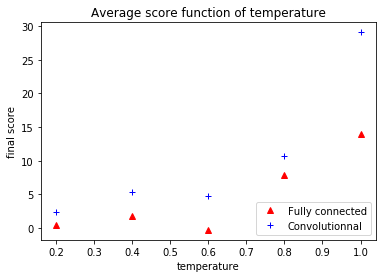

In [22]:
import matplotlib.pyplot as plt

plt.title("Average score function of temperature")
plt.xlabel("temperature")
plt.ylabel("final score")
plt.plot(temp_values,final_scores_FC,'r^',label='Fully connected')
plt.plot(temp_values,final_scores_CNN,'b+',label='Convolutionnal')
plt.legend(loc='lower right')
plt.show()



In [25]:
HTML(display_videos('cnn_test_1.00.mp4'))
##temperature = 1

In [26]:
HTML(display_videos('cnn_test_0.40.mp4'))

In [27]:

HTML(display_videos('fc_test_0.40.mp4'))

# Answer 9

- First we can clearly see that the mouse is not exploring enough. Both CNN and FC networks are stay at the same places.
- Secondly we can observe better performance for CNN, it is in adequation with the fact that it is a network adapted to pictural inputs which is the case in our example. We want the network to learn to spot the "good" cases and to learn to act toward them
- The temperature is the probability that a case get a malus or bonus. Given the fact that a bonus erase the malus on the same case, it is obvious that the higher the temperature, the higher the score (when temperature = 1 all the cases have a bonus). However it is not obvious which type of environment will ease the learning phase. Temperature around 0.4 offers a good trade-off between not enough bonus / malus and too much bonus.

***

The algorithm tends to not explore the map which can be an issue. We propose two ideas in order to encourage exploration:
1. Incorporating a decreasing $\epsilon$-greedy exploration. You can use the method ```set_epsilon```
2. Append via the environment a new state that describes if a cell has been visited or not

***
__Question 10__ Design a new ```train_explore``` function and environment class ```EnvironmentExploring``` to tackle the issue of exploration.



In [0]:
def train_explore(agent,env,epoch,prefix=''):
    pass
        
class EnvironmentExploring(object):
    def __init__(self, grid_size=10, max_time=500, temperature=0.1):
        pass
    
## use those samples of code:
#In train explore:
state, reward, game_over = env.act(action, train=True)

## In Environment exploring:
# You will have to change n_state to 3 because you will use one more layer!
reward = 0
if train:
    reward = -self.malus_position[self.x, self.y]
self.malus_position[self.x, self.y] = 0.1

reward = reward + self.board[self.x, self.y]
# 3 "feature" states instead of 2
state = np.concatenate((self.malus_position.reshape(self.grid_size, self.grid_size,1),
                                self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)

In [0]:
## The function train_explore has 2 mains differences :
## 1. For each epoch we change the epsilon-greedy value of the agent
## 2. the environment will 
def train_explore(agent,env,epoch,prefix=''):
    # Number of won games
    score = 0
    loss = 0

    for e in range(epoch):
        # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()
        # This assumes that the games will terminate
        game_over = False

        win = 0
        lose = 0
        ### Adding a change in the epsilon
        ### each epochs e is played with epsilon_e = espilon_0 / e
        if e+1 > 1:
            agent.set_epsilon(e+1)

        while not game_over:
            # The agent performs an action
            action = agent.act(state)

            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            prev_state = state
            state, reward, game_over = env.act(action,training=True)

            # Update the counters
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose -reward

            # Apply the reinforcement strategy
            loss = agent.reinforce(prev_state, state,  action, reward, game_over)

        # Save as a mp4
        if e % 10 == 0:
            env.draw(prefix+str(e))

        # Update stats
        score += win-lose

        print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
              .format(e, epoch, loss, win, lose, win-lose))
        agent.save(name_weights=prefix+'model.h5',name_model=prefix+'model.json')

In [0]:
class EnvironmentExploring(Environment):
      def __init__(self,grid_size=10,max_time=500,temperature=0.1):
          super(EnvironmentExploring,self).__init__(grid_size,max_time,temperature)

          self.malus_position = np.zeros((grid_size,grid_size))
  
      def reset(self):
          """This function resets the game and returns the initial state"""

          self.x = np.random.randint(3, self.grid_size-3, size=1)[0]
          self.y = np.random.randint(3, self.grid_size-3, size=1)[0]


          bonus = 0.5*np.random.binomial(1,self.temperature,size=self.grid_size**2)
          bonus = bonus.reshape(self.grid_size,self.grid_size)

          malus = -1.0*np.random.binomial(1,self.temperature,size=self.grid_size**2)
          malus = malus.reshape(self.grid_size, self.grid_size)

          self.to_draw = np.zeros((self.max_time+2, self.grid_size*self.scale, self.grid_size*self.scale, 3))


          malus[bonus>0]=0

          self.board = bonus + malus

          self.position = np.zeros((self.grid_size, self.grid_size))
          self.position[0:2,:]= -1
          self.position[:,0:2] = -1
          self.position[-2:, :] = -1
          self.position[-2:, :] = -1
          self.board[self.x,self.y] = 0
          self.t = 0

          #malus_position tracks the malus associated with each position, it starts at 0
          self.malus_position = np.zeros((self.grid_size,self.grid_size))
          self.malus_position[0:2,:]= -1
          self.malus_position[:,0:2] = -1
          self.malus_position[-2:, :] = -1
          self.malus_position[-2:, :] = -1

          state = np.concatenate((self.malus_position.reshape(self.grid_size, self.grid_size,1),
                                self.board.reshape(self.grid_size, self.grid_size,1),
                          self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)

          state = state[self.x - 2:self.x + 3, self.y - 2:self.y + 3, :]
          return state

      def act(self, action,training=False):
          """This function returns the new state, reward and decides if the
          game ends."""

          self.get_frame(int(self.t))

          self.position = np.zeros((self.grid_size, self.grid_size))

          self.position[0:2,:]= -1
          self.position[:,0:2] = -1
          self.position[-2:, :] = -1
          self.position[-2:, :] = -1

          self.position[self.x, self.y] = 1
          if action == 0:
              if self.x == self.grid_size-3:
                  self.x = self.x-1
              else:
                  self.x = self.x + 1
          elif action == 1:
              if self.x == 2:
                  self.x = self.x+1
              else:
                  self.x = self.x-1
          elif action == 2:
              if self.y == self.grid_size - 3:
                  self.y = self.y - 1
              else:
                  self.y = self.y + 1
          elif action == 3:
              if self.y == 2:
                  self.y = self.y + 1
              else:
                  self.y = self.y - 1
          else:
              RuntimeError('Error: action not recognized')

          self.t = self.t + 1

          #changes are here
          reward = 0
          if training == True:
            reward -= self.malus_position[self.x,self.y]
          #we update the malus_position
          #if never visited we add -0.2
          #else we add 10% until it reaches 0.6
          if self.malus_position[self.x, self.y] < 0.2:
              self.malus_position[self.x,self.y] = 0.2
          elif self.malus_position[self.x, self.y] < 0.6:
              self.malus_position[self.x, self.y] = self.malus_position[self.x, self.y] *1.1
          

          reward += self.board[self.x, self.y]
          self.board[self.x, self.y] = 0
          game_over = self.t > self.max_time
          state = np.concatenate((self.malus_position.reshape(self.grid_size, self.grid_size,1),
                          self.board.reshape(self.grid_size, self.grid_size,1),
                          self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)
          state = state[self.x-2:self.x+3,self.y-2:self.y+3,:]

          return state, reward, game_over


In [30]:
# Training
size = 13
T=200
temperature=0.3
epochs_train=15 # set small when debugging
epochs_test=5

env = EnvironmentExploring(grid_size=size, max_time=T, temperature=0.3)
agent = DQN_CNN(size, lr=.1, epsilon = 0.3, memory_size=2000, batch_size = 16,n_state=3)
train_explore(agent, env, epochs_train, prefix='cnn_train_explore')


Epoch 000/015 | Loss 0.0209 | Win/lose count 12.5/53.036654905736604 (-40.536654905736604)
Epoch 001/015 | Loss 0.0336 | Win/lose count 12.0/43.86830944157239 (-31.868309441572393)
Epoch 002/015 | Loss 0.0128 | Win/lose count 16.5/45.402203365707216 (-28.902203365707216)
Epoch 003/015 | Loss 0.0213 | Win/lose count 13.0/35.352821999999975 (-22.352821999999975)
Epoch 004/015 | Loss 0.0594 | Win/lose count 14.0/34.62717143999997 (-20.62717143999997)
Epoch 005/015 | Loss 0.0332 | Win/lose count 11.5/42.38510352688399 (-30.885103526883988)
Epoch 006/015 | Loss 0.0398 | Win/lose count 24.5/21.587999999999976 (2.912000000000024)
Epoch 007/015 | Loss 0.1374 | Win/lose count 20.5/28.61761999999998 (-8.117619999999981)
Epoch 008/015 | Loss 0.0118 | Win/lose count 20.5/30.215521999999968 (-9.715521999999968)
Epoch 009/015 | Loss 0.0354 | Win/lose count 17.5/36.84388682443998 (-19.343886824439977)
Epoch 010/015 | Loss 0.0224 | Win/lose count 23.5/27.17509961999999 (-3.6750996199999904)
Epoch 011/

In [31]:
HTML(display_videos('cnn_train_explore0.mp4'))

In [34]:
# Evaluation
test(agent,env,epochs_test,prefix='cnn_test_explore')
HTML(display_videos('cnn_test_explore0.mp4'))

Win/lose count 22.5/10.0. Average score (12.5)
Win/lose count 19.5/6.0. Average score (13.0)
Win/lose count 24.0/5.0. Average score (15.0)
Win/lose count 17.0/8.0. Average score (13.5)
Win/lose count 26.0/9.0. Average score (14.2)
Final score: 14.2


***
***
__BONUS question__ Use the expert DQN from the previous question to generate some winning games. Train a model that mimicks its behavior. Compare the performances.

***